In [1]:
import numpy as np
import pandas as pd
from scipy import stats

from scipy.spatial.distance import cdist
import odor_stat_calculations as osc
from scipy.stats import kurtosis
from scipy.stats import norm

import matplotlib.pyplot as plt 
import seaborn as sns
from figurefirst import FigureLayout,mpl_functions
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import wasserstein_distance
# from itertools import groupby
# from operator import itemgetter
import time

In [2]:

class OdorPredictor:
    def __init__(self, fitted_p_heatmap, xedges, yedges, fdf, fdf_nowhiff, distance_threshold=4, rows_per_second=200, base_odor_level=0.58):
        self.fitted_p_heatmap = fitted_p_heatmap
        self.xedges = xedges
        self.yedges = yedges
        self.distance_threshold = distance_threshold
        self.rows_per_second = rows_per_second
        self.base_odor_level = base_odor_level
        self.initialize_data(fdf, fdf_nowhiff)

    def initialize_data(self, fdf, fdf_nowhiff):
        # Extract necessary data as arrays for faster access
        self.whiff_locations = fdf[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
        self.nowhiff_locations = fdf_nowhiff[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
        self.whiff_means = fdf.mean_concentration.values
        self.whiff_stds = fdf.std_whiff.values
        self.whiff_duration = fdf.length_of_encounter.values
        self.nowhiff_means = fdf_nowhiff.wc_nowhiff.values
        self.nowhiff_wsd = fdf_nowhiff.wsd_nowhiff.values

    def predict_whiff_from_probability(self, x, y):
        x_bin = np.digitize(x, self.xedges) - 1
        y_bin = np.digitize(y, self.yedges) - 1
        if x_bin < 0 or x_bin >= self.fitted_p_heatmap.shape[0] or y_bin < 0 or y_bin >= self.fitted_p_heatmap.shape[1]:
            return False, 0
        whiff_prob = self.fitted_p_heatmap[x_bin, y_bin]
        return np.random.rand() < whiff_prob, whiff_prob

    @staticmethod
    def moving_average(data, window_size=5):
        # Adjust moving average to keep the same length as input data
        return np.convolve(data, np.ones(window_size)/window_size, mode='same')

    def predict_odor_concentration(self, x, y):
        # Convert DataFrame columns to NumPy arrays
        df_test = pd.DataFrame({'distance_along_streakline': x, 'nearest_from_streakline': y})
        odor_concentration_samples = np.full(len(df_test), self.base_odor_level)
        whiff_prediction_samples = np.zeros(len(df_test), dtype=int)

        test_locations = df_test[['distance_along_streakline', 'nearest_from_streakline']].values
        distances = cdist(test_locations, self.whiff_locations)
        distances_nowhiff = cdist(test_locations, self.nowhiff_locations)

        # Process whiff and no-whiff regions
        odor_concentration_samples, whiff_prediction_samples = self.process_whiff_regions(
            distances, odor_concentration_samples, whiff_prediction_samples, test_locations
        )
        odor_concentration_samples = self.process_no_whiff_regions(
            distances_nowhiff, odor_concentration_samples
        )

        # Return results as DataFrame
        df_test['predicted_odor'] = odor_concentration_samples
        df_test['whiff_predicted'] = whiff_prediction_samples
        return df_test

    def process_whiff_regions(self, distances, odor_concentration_samples, whiff_prediction_samples, test_locations):
        for i, (dist_along, nearest_from) in enumerate(test_locations):
            whiff_predicted, _ = self.predict_whiff_from_probability(dist_along, nearest_from)
            if whiff_predicted and np.min(distances[i]) <= self.distance_threshold:
                nearest_whiff_idx = np.argmin(distances[i])
                mean_concentration = self.whiff_means[nearest_whiff_idx]
                std_dev_whiff = self.whiff_stds[nearest_whiff_idx]
                duration = int(self.whiff_duration[nearest_whiff_idx] * self.rows_per_second)
                rows_to_fill = min(duration, len(odor_concentration_samples) - i)

                generated_concentrations = np.random.normal(mean_concentration, std_dev_whiff, rows_to_fill)
                generated_concentrations = np.clip(generated_concentrations, 4, 10.2)
                odor_concentration_samples[i:i + rows_to_fill] = generated_concentrations
                whiff_prediction_samples[i:i + rows_to_fill] = 1
        return odor_concentration_samples, whiff_prediction_samples

    def process_no_whiff_regions(self, distances_nowhiff, odor_concentration_samples):
        i = 0
        while i < len(odor_concentration_samples):
            if odor_concentration_samples[i] == self.base_odor_level:
                nearest_no_whiff_idx = np.argmin(distances_nowhiff[i])
                no_whiff_mean = self.nowhiff_means[nearest_no_whiff_idx]
                no_whiff_std = self.nowhiff_wsd[nearest_no_whiff_idx]

                start = i
                while i < len(odor_concentration_samples) and odor_concentration_samples[i] == self.base_odor_level:
                    i += 1
                end = i

                no_whiff_concentrations = np.random.normal(no_whiff_mean, no_whiff_std, end - start)
                no_whiff_concentrations = np.clip(no_whiff_concentrations, 0.58, 1)
                
                # Check if moving average should be applied
                if end - start >= 5:  # Apply only if length >= window size
                    smoothed_concentrations = self.moving_average(no_whiff_concentrations, window_size=5)
                    odor_concentration_samples[start:end] = smoothed_concentrations[:end - start]
                else:
                    odor_concentration_samples[start:end] = no_whiff_concentrations
            else:
                i += 1
        return odor_concentration_samples

if __name__ == "__main__":
    t = time.time()
    dirname = '../data/simulator/hws/'
    hmap_data = np.load(str(dirname) + "hmap_with_edges.npz")
    
    predictor = OdorPredictor(
        fitted_p_heatmap=hmap_data['fitted_p_heatmap'],
        xedges=hmap_data['xedges'],
        yedges=hmap_data['yedges'],
        fdf=pd.read_hdf(str(dirname) + 'whiff.h5'),
        fdf_nowhiff=pd.read_hdf(str(dirname) + 'nowhiff.h5')
    )
    
    df = pd.read_hdf(str(dirname) + 'hwsDesert.h5')
    df_test = df[10000:].reset_index(drop=True)
    x = df_test.distance_along_streakline.values
    y = df_test.nearest_from_streakline.values
    
    pdf = predictor.predict_odor_concentration(x, y)

    print(time.time()-t)

11.281612873077393


(      avg_dist_from_source  log_avg_dist_from_source  mean_concentration  \
 0                 1.606772                  0.205954           10.177610   
 1                 1.584458                  0.199881           10.070704   
 2                 1.552169                  0.190939            4.146179   
 3                 1.519115                  0.181591            9.751112   
 4                 1.519692                  0.181756            4.224644   
 ...                    ...                       ...                 ...   
 2936              4.553513                  0.658347            9.518903   
 2937              4.218414                  0.625149            8.691414   
 2938              4.131861                  0.616146            8.002565   
 2939              4.065270                  0.609089            8.833586   
 2940              3.960680                  0.597770            8.483766   
 
       length_of_encounter  odor_intermittency  log_whiff  log_blank  \
 0

In [31]:
# fitted_p_heatmap=hmap_data['fitted_p_heatmap'],
# xedges=hmap_data['xedges'],
# yedges=hmap_data['yedges'],

In [32]:
# print(type(fitted_p_heatmap))


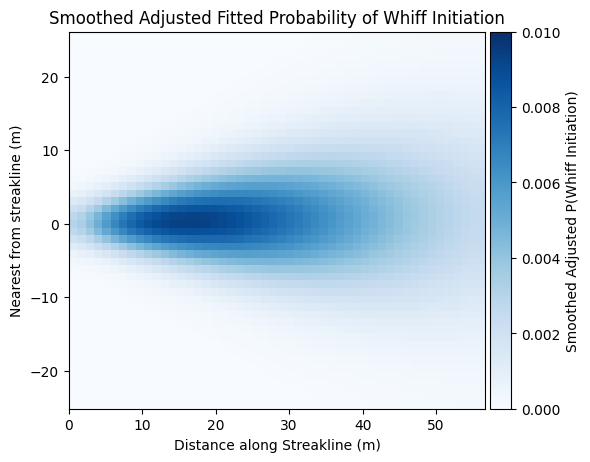

In [44]:
# # Correctly load each individual element
# fitted_p_heatmap = hmap_data['fitted_p_heatmap']
# xedges = hmap_data['xedges']
# yedges = hmap_data['yedges']

# # Plot the smoothed adjusted heatmap
# f, ax = plt.subplots(1, 1, figsize=(6, 6))
# cax = ax.imshow(
#     fitted_p_heatmap.T,
#     origin='lower',
#     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
#     cmap='Blues', vmin=0, vmax=0.01
# )

# divider = make_axes_locatable(ax)
# cbar = divider.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(cax, cax=cbar, label='Smoothed Adjusted P(Whiff Initiation)')
# ax.set_xlabel('Distance along Streakline (m)')
# ax.set_ylabel('Nearest from streakline (m)')
# ax.set_title('Smoothed Adjusted Fitted Probability of Whiff Initiation')

# f.tight_layout()
# plt.show()


In [46]:
df_test['predicted_odor']=pdf.predicted_odor
df_test['whiff_predicted']=pdf.whiff_predicted

In [47]:
th=4.5
query1 = 'odor>4.5'
new_test_df1=pd.DataFrame()
new_test_df1 = df_test.query(query1)
new_test_df1.reset_index(inplace=True, drop=True)

query2 = 'predicted_odor>4.5'
new_test_df2=pd.DataFrame()
new_test_df2 = df_test.query(query2)
new_test_df2.reset_index(inplace=True, drop=True)

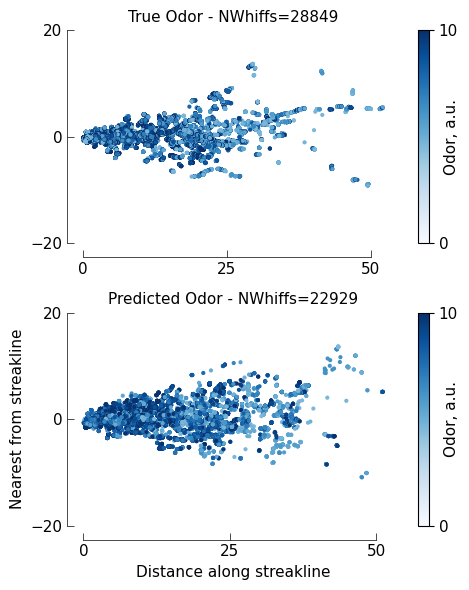

In [49]:
f, ax = plt.subplots(2, 1, figsize=(5, 6))

cax1 = ax[0].scatter(new_test_df1.distance_along_streakline, new_test_df1.nearest_from_streakline, c=new_test_df1.odor, s = 4, cmap='Blues', vmin=0, vmax=10)
cax2 = ax[1].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.predicted_odor, s = 4, cmap='Blues', vmin=0, vmax=10)
# cax3 = ax[2].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.whiff_predicted, s = 4, cmap='Blues', vmin=0, vmax=1)
# ylim=(-15,25)

ax[0].set_title('True Odor - NWhiffs='+str(len(new_test_df1)))
ax[1].set_title('Predicted Odor - NWhiffs='+str(len(new_test_df2)))
# ax[2].set_title('Whiff Onset Locations')
ax[1].set_xlabel('Distance along streakline')
ax[1].set_ylabel('Nearest from streakline')

cb1=plt.colorbar(cax1)
cb2=plt.colorbar(cax2)
# cb3=plt.colorbar(cax3)

cb1.set_label('Odor, a.u.',labelpad=-10)
cb2.set_label('Odor, a.u.',labelpad=-10)
# cb3.set_label('P(Whiff Onset)',labelpad=-10)

cb1.set_ticks([0,10])
cb2.set_ticks([0,10])
# cb3.set_ticks([0, 1])
for i in range(2):
    mpl_functions.adjust_spines(ax[i],['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[0,25,50],
                            yticks=[-20,0,20],
                            linewidth=0.5)
    mpl_functions.set_fontsize(ax[i],11)

f.tight_layout()

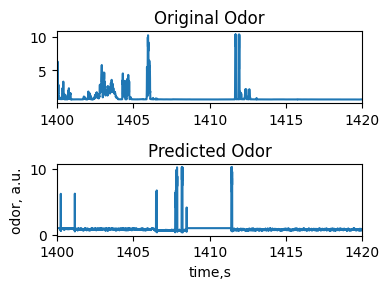

In [60]:
f,(ax1,ax2)= plt.subplots(2,1,figsize=(4,3))
ax1.plot(df_test.time, df_test.odor, label='original')
# plt.plot(df_test.smoothed_odor, label='smoothed')
ax2.plot(df_test.time, df_test.predicted_odor, label='predicted')
# ax2.axhline(4, color = 'r', linestyle = '--')

limit=(1400,1420)
# limit = (158,165)
ax1.set_xlim(limit)
ax2.set_xlim(limit)
# ax2.set_ylim(0,1)

ax2.set_ylabel('odor, a.u.')
ax2.set_xlabel('time,s')
ax1.set_title('Original Odor')
ax2.set_title('Predicted Odor')
f.tight_layout()

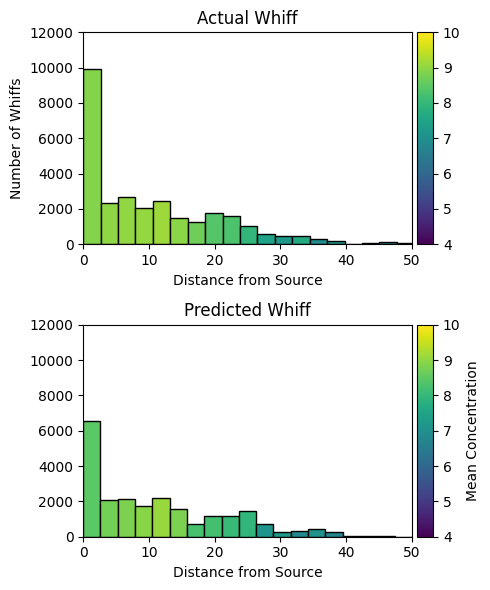

In [63]:
n_bins = 20
ylim = (0,12000)
# Actual Whiff Data
df_actual = new_test_df1.copy()
bins = np.linspace(0, df_actual['distance_from_source'].max(), n_bins + 1)
df_actual['distance_bin'] = pd.cut(df_actual['distance_from_source'], bins=bins)

whiff_counts_actual = df_actual.groupby('distance_bin').size()
mean_concentrations_actual = df_actual.groupby('distance_bin')['odor'].mean()
bin_centers_actual = (bins[:-1] + bins[1:]) / 2

# Predicted Whiff Data
df_predicted = new_test_df2.copy()
bins_predicted = np.linspace(0, df_predicted['distance_from_source'].max(), n_bins + 1)
df_predicted['distance_bin'] = pd.cut(df_predicted['distance_from_source'], bins=bins_predicted)

whiff_counts_predicted = df_predicted.groupby('distance_bin').size()
mean_concentrations_predicted = df_predicted.groupby('distance_bin')['predicted_odor'].mean()
bin_centers_predicted = (bins_predicted[:-1] + bins_predicted[1:]) / 2

# Create the subplots
f, ax = plt.subplots(2, 1, figsize=(5, 6))

# Plot for Actual Whiff Data
norm_actual = plt.Normalize(4, 10)
colors_actual = plt.cm.viridis(norm_actual(mean_concentrations_actual))
bars_actual = ax[0].bar(bin_centers_actual, whiff_counts_actual, width=(bins[1] - bins[0]), edgecolor='black', color=colors_actual)

divider_actual = make_axes_locatable(ax[0])
cax_actual = divider_actual.append_axes("right", size="5%", pad=0.05)
sm_actual = plt.cm.ScalarMappable(cmap='viridis', norm=norm_actual)
sm_actual.set_array([])
cbar_actual = plt.colorbar(sm_actual, cax=cax_actual)
# cbar_actual.set_label('Mean Concentration')

ax[0].set_xlabel('Distance from Source')
ax[0].set_ylabel('Number of Whiffs')
ax[0].set_title('Actual Whiff')
ax[0].set_ylim(ylim)
ax[0].set_xlim(0,50)
# Plot for Predicted Whiff Data
norm_predicted = plt.Normalize(4, 10)
colors_predicted = plt.cm.viridis(norm_predicted(mean_concentrations_predicted))
bars_predicted = ax[1].bar(bin_centers_predicted, whiff_counts_predicted, width=(bins_predicted[1] - bins_predicted[0]), edgecolor='black', color=colors_predicted)

divider_predicted = make_axes_locatable(ax[1])
cax_predicted = divider_predicted.append_axes("right", size="5%", pad=0.05)
sm_predicted = plt.cm.ScalarMappable(cmap='viridis', norm=norm_predicted)
sm_predicted.set_array([])
cbar_predicted = plt.colorbar(sm_predicted, cax=cax_predicted)
cbar_predicted.set_label('Mean Concentration')

ax[1].set_xlabel('Distance from Source')
ax[1].set_title('Predicted Whiff')
ax[1].set_ylim(ylim)
ax[1].set_xlim(0,50)
f.tight_layout()



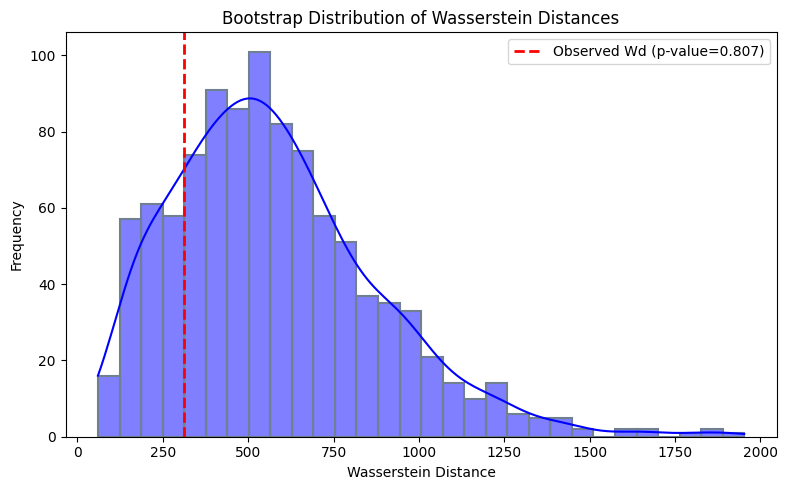

In [39]:


true_data = whiff_counts_actual.values  # Actual whiff counts
predicted_data = whiff_counts_predicted.values
# Calculate the observed Wasserstein distance
observed_wd = wasserstein_distance(true_data, predicted_data)

# Define the function to calculate bootstrap Wasserstein distances
def bootstrap_wasserstein(true_data, predicted_data, n_bootstraps=1000):
    combined_data = np.concatenate([true_data, predicted_data])
    bootstrap_distances = []
    for _ in range(n_bootstraps):
        bootstrap_true = np.random.choice(combined_data, size=len(true_data), replace=True)
        bootstrap_predicted = np.random.choice(combined_data, size=len(predicted_data), replace=True)
        bootstrap_distances.append(wasserstein_distance(bootstrap_true, bootstrap_predicted))
    return bootstrap_distances

# Perform bootstrap sampling
n_bootstraps = 1000
bootstrap_distances = bootstrap_wasserstein(true_data, predicted_data, n_bootstraps)

# Calculate the p-value
p_value = np.mean(np.array(bootstrap_distances) >= observed_wd)

# Plot the bootstrap distribution
plt.figure(figsize=(8, 5))
sns.histplot(bootstrap_distances, bins=30, kde=True, color='blue', edgecolor='slategray', linewidth=1.5)
plt.axvline(observed_wd, color='red', linestyle='--', linewidth=2, label=f'Observed Wd (p-value={p_value:.3f})')
plt.title('Bootstrap Distribution of Wasserstein Distances')
plt.xlabel('Wasserstein Distance')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.tight_layout()

In [40]:
new_test_df1=df_test.copy()
new_test_df2=df_test.copy()

def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

def cal_stat_predicted(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.predicted_mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff_predicted(df,idx,df2)
    osc.mean_avg_predicted(df,idx,df2)
    osc.encounter_frequency_predicted(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)
th = 4.5
np.seterr(divide='ignore')
index = osc.get_index(new_test_df1.odor,th)
index_predicted = osc.get_index(new_test_df2.predicted_odor,th)
fdf1 = pd.DataFrame()
fdf_predicted = pd.DataFrame()

cal_stat(new_test_df1,index,fdf1)
cal_stat_predicted(new_test_df2,index_predicted, fdf_predicted)

fdf1.keys()

/home/gorilla/An/plume_sim/odor_stat_calculations.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.efreq.iloc[start] = 1


Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'mean_concentration', 'length_of_encounter', 'odor_intermittency',
       'log_whiff', 'log_blank', 'std_whiff', 'whiff_ma', 'wf', 'mean_time'],
      dtype='object')

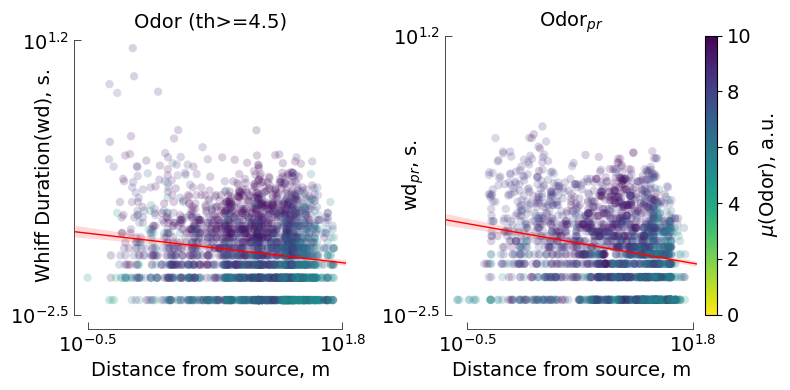

In [41]:
### WHIFF DURATION
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf1.log_avg_dist_from_source,fdf1.log_whiff, c=fdf1.mean_concentration, cmap='viridis_r',edgecolors='none', 
                 alpha=0.2,vmin=0,vmax=10  )
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf1.log_avg_dist_from_source,y=fdf1.log_whiff , data=fdf1,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.08)
# cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
# cbar.solids.set(alpha=1)
# cbar.set_label('$\mu$(WC), a.u.')

ax1.set_xlabel('Distance from source, m')
ax1.set_ylabel('Whiff Duration(wd), s.')
ax1.set_title('Odor (th>='+str(th)+')')
ax1.yaxis.set_label_coords(-0.08, 0.5)

u=ax2.scatter(fdf_predicted.log_avg_dist_from_source,
              fdf_predicted.log_whiff, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r',edgecolors='none', 
                 alpha=0.2, vmin=0,vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source,y=fdf_predicted.log_whiff , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(Odor), a.u.')

ax2.set_xlabel('Distance from source, m')
ax2.set_title('Odor$_{pr}$')
ax2.set_ylabel('wd$_{pr}$, s.')
ax2.yaxis.set_label_coords(-0.08, 0.5)
mpl_functions.adjust_spines(ax1,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[-0.5,1.8],
                            yticks=[-2.5,1.2],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[-0.5,1.8],
                            yticks=[-2.5,1.2],
                            linewidth=0.5)
ax1.set_yticklabels([r'$10^{-2.5}$',r'$10^{1.2}$'])
ax1.set_xticklabels([r'$10^{-0.5}$',r'$10^{1.8}$'])
ax2.set_yticklabels([r'$10^{-2.5}$',r'$10^{1.2}$'])
ax2.set_xticklabels([r'$10^{-0.5}$',r'$10^{1.8}$'])

mpl_functions.set_fontsize(f, 14)
f.tight_layout()


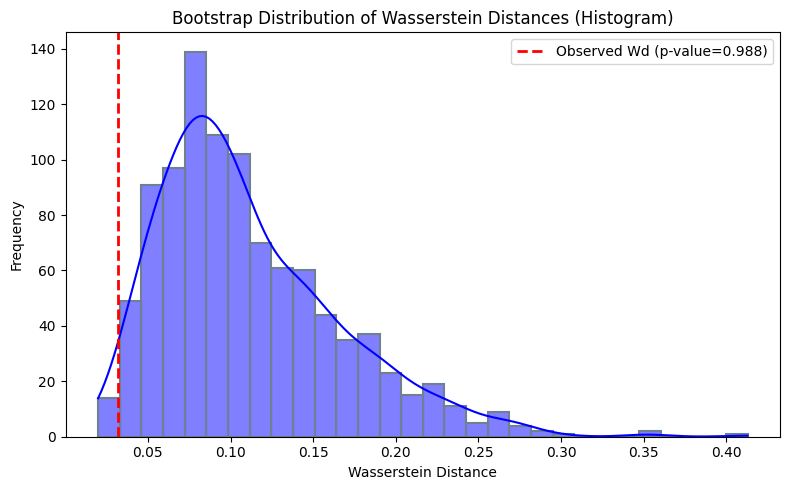

In [43]:
bins = np.linspace(min(fdf1.log_whiff.min(), fdf_predicted.log_whiff.min()),
                   max(fdf1.log_whiff.max(), fdf_predicted.log_whiff.max()), 20)

# Calculate histogram counts
true_hist, _ = np.histogram(fdf1.log_whiff, bins=bins, density=True)
pred_hist, _ = np.histogram(fdf_predicted.log_whiff, bins=bins, density=True)

# Calculate observed Wasserstein distance
observed_wd = wasserstein_distance(true_hist, pred_hist)

# Bootstrapping for histogram-based comparison
bootstrap_distances = bootstrap_wasserstein(true_hist, pred_hist, n_bootstraps=1000)
p_value = np.mean(np.array(bootstrap_distances) >= observed_wd)
# Plot bootstrap results
plt.figure(figsize=(8, 5))
sns.histplot(bootstrap_distances, bins=30, kde=True, color='blue', edgecolor='slategray', linewidth=1.5)
plt.axvline(observed_wd, color='red', linestyle='--', linewidth=2, label=f'Observed Wd (p-value={p_value:.3f})')
plt.title('Bootstrap Distribution of Wasserstein Distances (Histogram)')
plt.xlabel('Wasserstein Distance')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()